<a href="https://colab.research.google.com/github/mrozikk/Project_ARPDATA/blob/master/Analiza%20sentymentu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analiza sentymentu  na danych pobranych z  Amazon, Yelp i Imdb 
https://www.kaggle.com/datasets/akashkumar01/yelpamazonimdb

Celem jest na podstawie zdania rozpoznanie czy jest to komentarz pozytywny czy negatywny.


##Pobranie i eksploracja danych

In [44]:
from google.colab import files

In [45]:
files.upload()

{}

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import string
from __future__ import division
from textblob import TextBlob
import math

In [47]:
filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}


In [48]:
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)
    print(df_list)

[                                              sentence  label source
0                             Wow... Loved this place.      1   yelp
1                                   Crust is not good.      0   yelp
2            Not tasty and the texture was just nasty.      0   yelp
3    Stopped by during the late May bank holiday of...      1   yelp
4    The selection on the menu was great and so wer...      1   yelp
..                                                 ...    ...    ...
995  I think food should have flavor and texture an...      0   yelp
996                           Appetite instantly gone.      0   yelp
997  Overall I was not impressed and would not go b...      0   yelp
998  The whole experience was underwhelming, and I ...      0   yelp
999  Then, as if I hadn't wasted enough of my life ...      0   yelp

[1000 rows x 3 columns]]
[                                              sentence  label source
0                             Wow... Loved this place.      1   yelp
1     

In [49]:
#łączymy dane 
df = pd.concat(df_list)
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2748 non-null   object
 1   label     2748 non-null   int64 
 2   source    2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


#sprawdzenie zbilansowania danych

In [51]:
df['label'].value_counts()

1    1386
0    1362
Name: label, dtype: int64

In [52]:
neg1_files = df[df["label"] == 0]
neg_files = neg1_files['sentence']

In [53]:
pos1_files = df[df["label"] == 1]
pos_files = pos1_files['sentence']

##Czyszczenie danych

In [54]:
stemmer = nltk.SnowballStemmer("english")

from nltk.corpus import stopwords
nltk.download('stopwords')

stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
def clean(dane):
  dane = str(dane).lower()
  dane = re.sub('\[.*?\]', '', dane)
  dane = re.sub('https?://\S+|www\.\S+', '', dane)
  dane = re.sub('<.*?>+', '', dane)
  dane = re.sub('[%s]' % re.escape(string.punctuation), '', dane)
  dane = re.sub('\n', '', dane)
  dane = re.sub('\w*\d\w*', '', dane)
  dane = [word for word in dane.split(' ') if word not in stopword]
  dane = " ".join(dane)
  dane = [stemmer.stem(word) for word in dane.split(' ')]
  dane = " ".join(dane)
  return dane

df['sentence'] = df['sentence'].apply(clean)


sentence=" ".join(i for i in df.sentence)
pos_sent=" ".join(i for i in pos_files)
neg_sent=" ".join(i for i in neg_files)

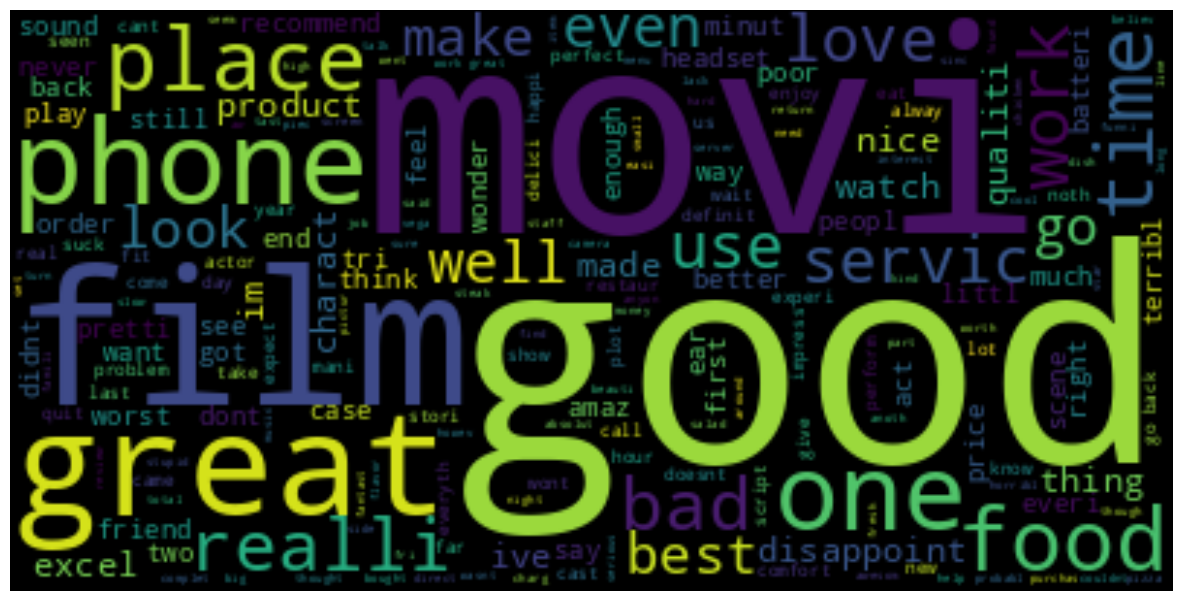

In [56]:
#słowa z całego zbioru danych
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(sentence)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

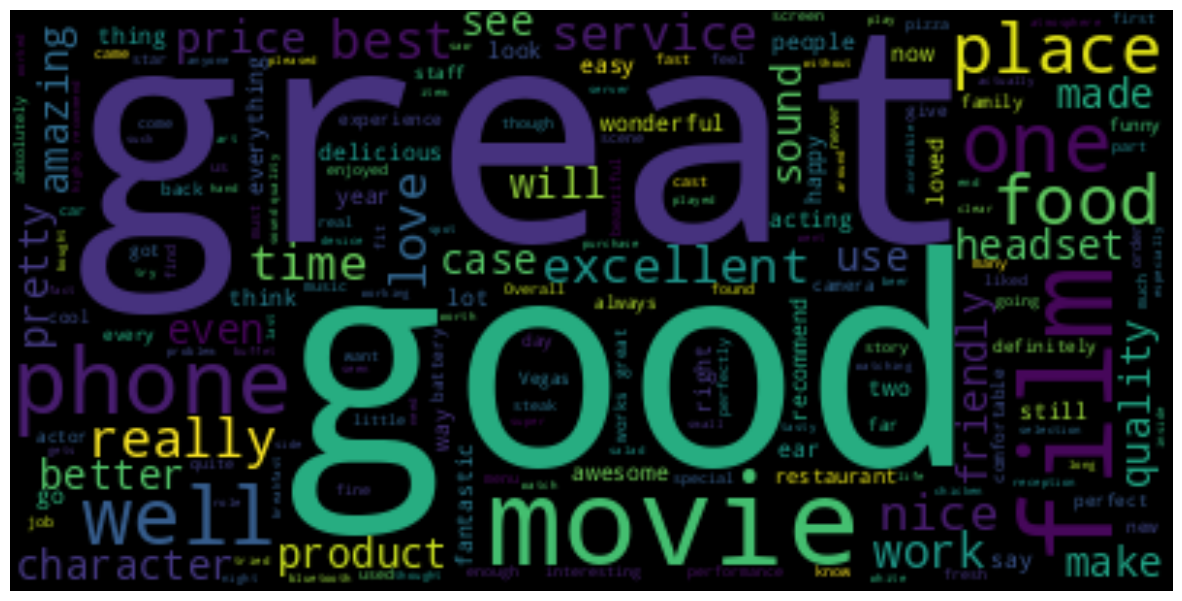

In [57]:
#pozytywne słowa
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(pos_sent)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

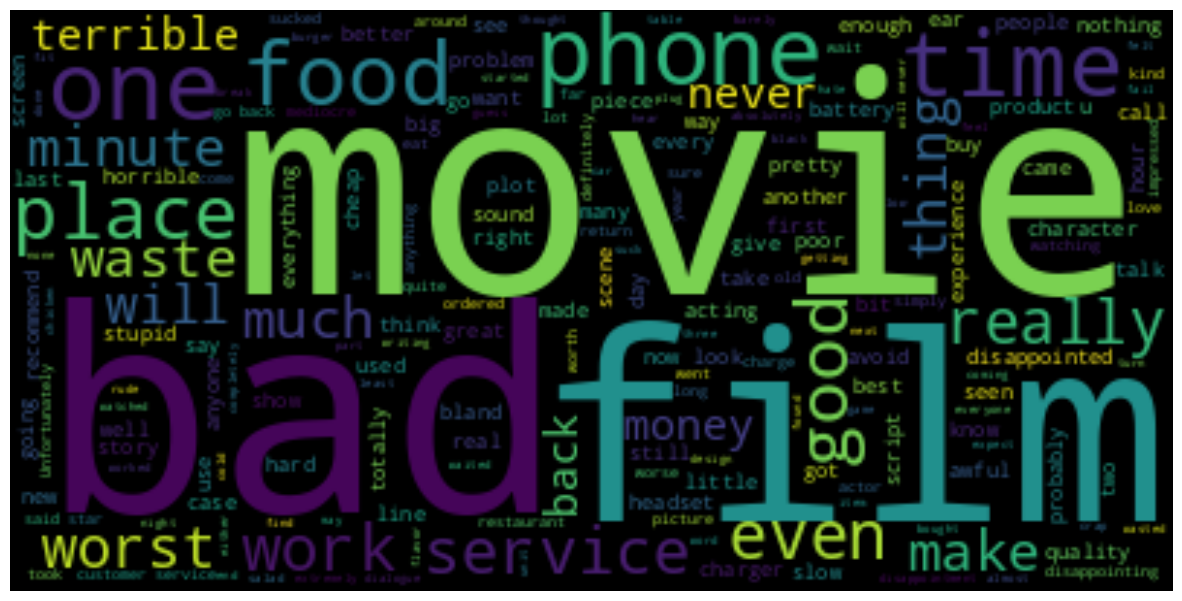

In [58]:
#negatywne słowa
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(neg_sent)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Podział danych na zbiór treningowy i testowy


In [59]:
X=df['sentence']
y=df['label']

In [60]:
#Podział zbioru na treningowy i walidacyjny
X_train, X_valid, y_train, y_valid = train_test_split(
X, y, test_size=0.3, random_state=23)

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
#wektoryzacja danych
vect = CountVectorizer()
vect.fit(X_train)
CountVectorizer()

CountVectorizer()

In [62]:

X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_valid)

In [63]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=200)

In [64]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<1923x3378 sparse matrix of type '<class 'numpy.float64'>'
	with 12460 stored elements in Compressed Sparse Row format>

In [65]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [66]:

y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)


In [67]:
# Wynik Accuracy

from sklearn.metrics import confusion_matrix
print(accuracy_score(y_valid, y_pred_class))


0.7915151515151515


Jeszcze raz - po TFIDF

In [68]:
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [69]:
y_pred_class_tfidf = nb.predict(X_test_dtm)
y_pred_prob_tfidf = nb.predict_proba(X_test_dtm)

In [70]:
# Wynik Accuracy TFIDF
print(accuracy_score(y_valid, y_pred_class_tfidf))

0.8072727272727273


#UCZENIE ZBIORU Z UŻYCIEM SIMPLE T5

In [ ]:
!pip install pytorch_lightning
!pip install sentencepiece
!pip install transformers
import pytorch_lightning


In [ ]:
!pip install simplet5

In [73]:
from simplet5 import SimpleT5

In [74]:
model = SimpleT5()

In [75]:
model.from_pretrained("t5","t5-base")

In [76]:
df2=df
df2.drop(columns=['source'], inplace=True)

In [77]:
df2 = df2.applymap(str)
df2 = df2.rename(columns={"label":"target_text", "sentence":"source_text"})
df2 = df2[['source_text', 'target_text']]
df2['source_text'] = "binary classification " + df2['source_text']
df2.head()


,source_text,target_text
0,binary classification wow love place,1
1,binary classification crust good,0
2,binary classification tasti textur nasti,0
3,binary classification stop late may bank holid...,1
4,binary classification select menu great price,1


In [78]:
train_df, test_df = train_test_split(df2, test_size=0.2)
train_df.shape, test_df.shape

((2198, 2), (550, 2))

In [79]:
model.train(train_df=train_df,
            eval_df=test_df, 
            source_max_token_len=128, 
            target_max_token_len=1, 
            batch_size=10, 
            max_epochs=3, 
            use_gpu=True, 
            outputdir = "outputs",
          )

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [101]:
source_text="binary classification I hate this movie"

In [87]:
model.load_model("t5","outputs/simplet5-epoch-2-train-loss-0.0007-val-loss-0.0", use_gpu=True)

Testowanie przetrenowanego modułu

In [108]:
print(model.predict("binary classification Love this"))
print(model.predict("binary classification Anger hate enough"))
print(model.predict("binary classification need help"))
print(model.predict("Its not working as it should"))

['']
['']
['']
['Its not working as it should.']


Wnioski: coś schrzaniłam :) Popatrzę w weekend lub chętnie przyjmę pomoc 